## Homework 1
1. Perform <b>Adaptive Background Subtraction</b>. i.e., <i>S(t)=abs(I(t)-B(t))</i> where <i>B(t)</i> is the adaptive background image.
2. Perform <b>Foreground Detection</b>. i.e., <i>F(t)=I(t) if S(t) > Threshold</i>
3. Show the captured image <i>I(t)</i>, the adaptive background image <i>B(t)</i>, the subtracted image <i>S(t)</i>, and the foreground image <i>F(t)</i>.
4. Adjust the alpha value and observe the result.
5. Any idea on how to generate a better Adaptive Background Image? Try it and compare the results.
6. Write down your observation and comparison at the end of your code by adding an individual cell in Jupyter.
7. Upload your Jupyter code file (*.ipynb)
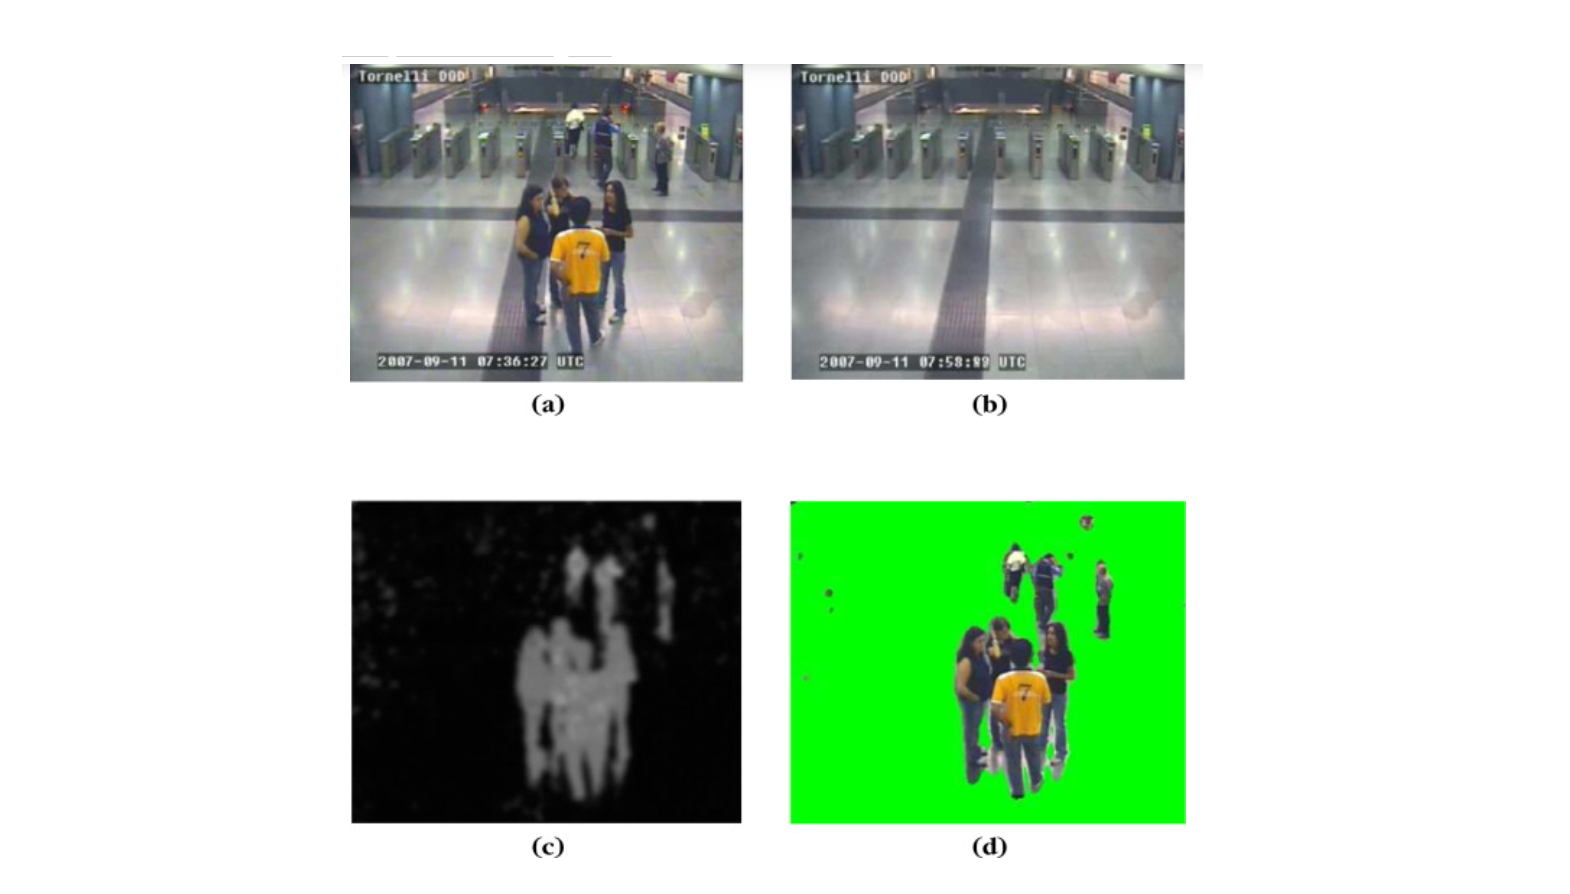

---

這次嘗試使用了兩種方法做背景分割:
1. 使用addWeighted做動態背景，並與當前影像相減，得到在移動中的物件。
2. 使用BackgroundSubtractorKNN直接做背景分割。

### Method 01 - using cv2.addWeighted

In [7]:
import cv2
import numpy as np


# Open the webcam 
cap = cv2.VideoCapture(1)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
alpha = 0.95

# read in the first frame
ret, first_frame = cap.read()
# resize the first frame and store it in cur_frame and mhi_frame
cur_frame = mhi_frame = cv2.resize(first_frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

# Create a background
bg = np.zeros(cur_frame.shape, np.uint8)
# Set the background color to B:255, G:0, R:100
bg[:,:,0] = 255
bg[:,:,2] = 100

while True:
    ret, frame = cap.read()
    # Resize current frame
    cur_frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    
    # Make the Adaptive background
    mhi_frame = cv2.addWeighted(mhi_frame, alpha, cur_frame, 1-alpha, 0.5)
    
    # Compute the difference between current frame and the Adaptive background
    diff_frame = cv2.absdiff(cur_frame, mhi_frame)
    
    # scaled the difference between two images, makes it easier to distinguish
    diff_frame = diff_frame * 2
    
    # Let it be under 255 after scaling    
    diff_frame = np.where(diff_frame[:,:,:] > 255, 255, diff_frame)
    
    # Convert the difference in gray scale, for masking
    diff_gray = cv2.cvtColor(diff_frame, cv2.COLOR_BGR2GRAY)
    
    # to smoothen the edges
    diff_gray_guss = cv2.GaussianBlur(diff_gray,(3,3), 0)
    
    # to smoothen the edges
    diff_gray_guss = cv2.dilate(diff_gray_guss, (3,3,3))
    
    # making a binary mask
    ret ,thr = cv2.threshold(diff_gray_guss, 30, 255, cv2.THRESH_BINARY)
    
    # Generate the foreground, with blackground
    for_img = cv2.bitwise_and(cur_frame, cur_frame, mask= thr)
    
    # Generate the background mask
    thr_inv = cv2.bitwise_not(thr)
    
    # Colored the backgeound
    bg_frame = cv2.bitwise_and(bg, bg, mask=thr_inv)
    
    # Add the colored background and the foreground
    result_img = cv2.add(for_img, bg_frame)
        
    # Show the current frame
    cv2.imshow('captured image', cur_frame)
    # Show the adaptive background
    cv2.imshow('adaptive background image', mhi_frame)
    # Show the subtracted image
    cv2.imshow('subtracted image ', diff_gray)
    # Show the foreground image
    cv2.imshow('foreground image', result_img)
    
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

### Method 02 - using BackgroundSubtractorKNN

In [3]:
import cv2
import numpy as np


# Open the webcam 
cap = cv2.VideoCapture(1)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# read in the first frame
ret, first_frame = cap.read()
# resize the first frame and store it in cur_frame and mhi_frame
cur_frame = mhi_frame = cv2.resize(first_frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

# Create a background
bg = np.zeros(cur_frame.shape, np.uint8)
# Set the background color to B:255, G:0, R:100
bg[:,:,0] = 255
bg[:,:,2] = 100

knn = cv2.createBackgroundSubtractorKNN(history = 100, dist2Threshold = 500.0, detectShadows=True)


while True:
    ret, frame = cap.read()
    # Resize current frame
    cur_frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    
    # Substract the background
    fgmask = knn.apply(cur_frame) 
    
    # Smoothen the edges
    fg_guss = cv2.GaussianBlur(fgmask, (3,3), 0)
    
    # to smoothen the edges
    fg_guss = cv2.dilate(fg_guss, (3,3,3))
    
    # making a binary mask
    ret, thr = cv2.threshold(fg_guss, 20, 255, cv2.THRESH_BINARY)
    
    # Generate the foreground, with blackground
    for_img = cv2.bitwise_and(cur_frame, cur_frame, mask= thr)
    
    # Generate the background mask
    thr_inv = cv2.bitwise_not(thr)
    
    # Colored the backgeound
    bg_frame = cv2.bitwise_and(bg, bg, mask=thr_inv)
    
    # Add the colored background and the foreground
    result_img = cv2.add(for_img, bg_frame)
    
    # Show the current frame
    cv2.imshow('captured image', cur_frame)
    # Show the adaptive background
    # cv2.imshow('adaptive background image', mhi_frame)
    # Show the subtracted image
    cv2.imshow('subtracted image ', fgmask)
    # Show the foreground image
    cv2.imshow('foreground image', result_img)
        
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

----

這次嘗試了兩種方法去做背景分割。

第一種使用addWeight對背景做加權，讓他可以因應逐漸改變的背景。嘗試過不同的Alpha值，並發現結果設為0.95的效果最佳，據觀察，如果Alpha值設太小，背景改變得太快，比較難看出與當前影格的影像差值，而如果Alpha值設得太大，移動的軌跡會成為背景的一部分，會干擾去背的效果。第二種使用OpenCV中的K-Nearest (KNN)背景分割器做背景分割。兩種方法都有使用高斯模糊去柔化邊緣，並使用膨脹擴增邊緣。背景置換的方法是，利用相反的遮罩將前景與背景分別做成黑底的圖片並進行疊加，原本使用np.where函式將RGB為0的地方(也就是遮罩蓋到的地方)進行與背景的像素置換，不過後來發現，他會將R、G、B單獨為0的像素也進行置換，顏色就跑掉了，因此才改成現在這種方法。
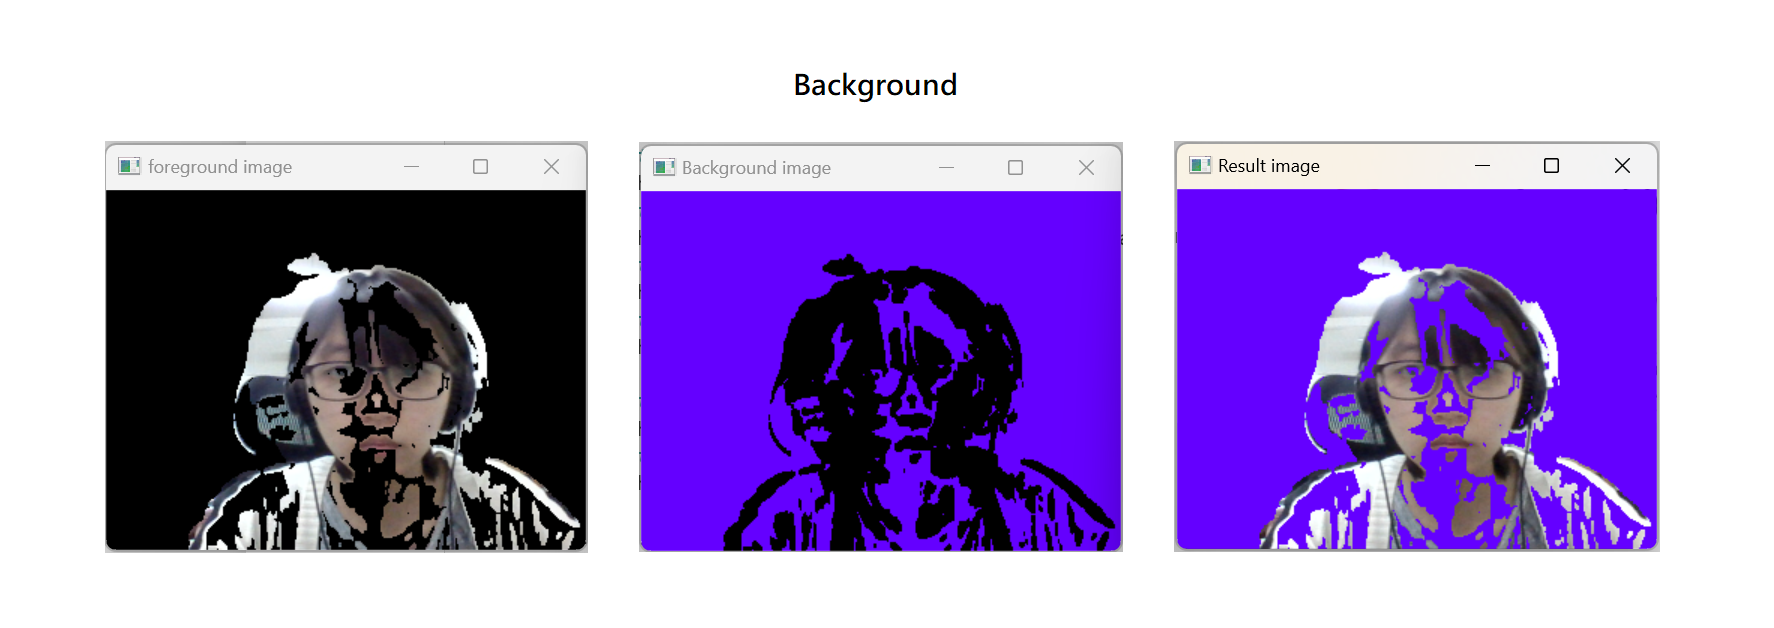

兩種背景分割方法的相同之處在於，在<b>前景移動時</b>都比較容易分辨前景與背景，邊緣部分也比較明顯，而色塊(如人的皮膚、衣服、頭髮等)在分辨時會比較難分割。至於效果，第二種方式比第一種還好，不過使用第二種方式沒有動態背景影像，只有分割出來的結果。
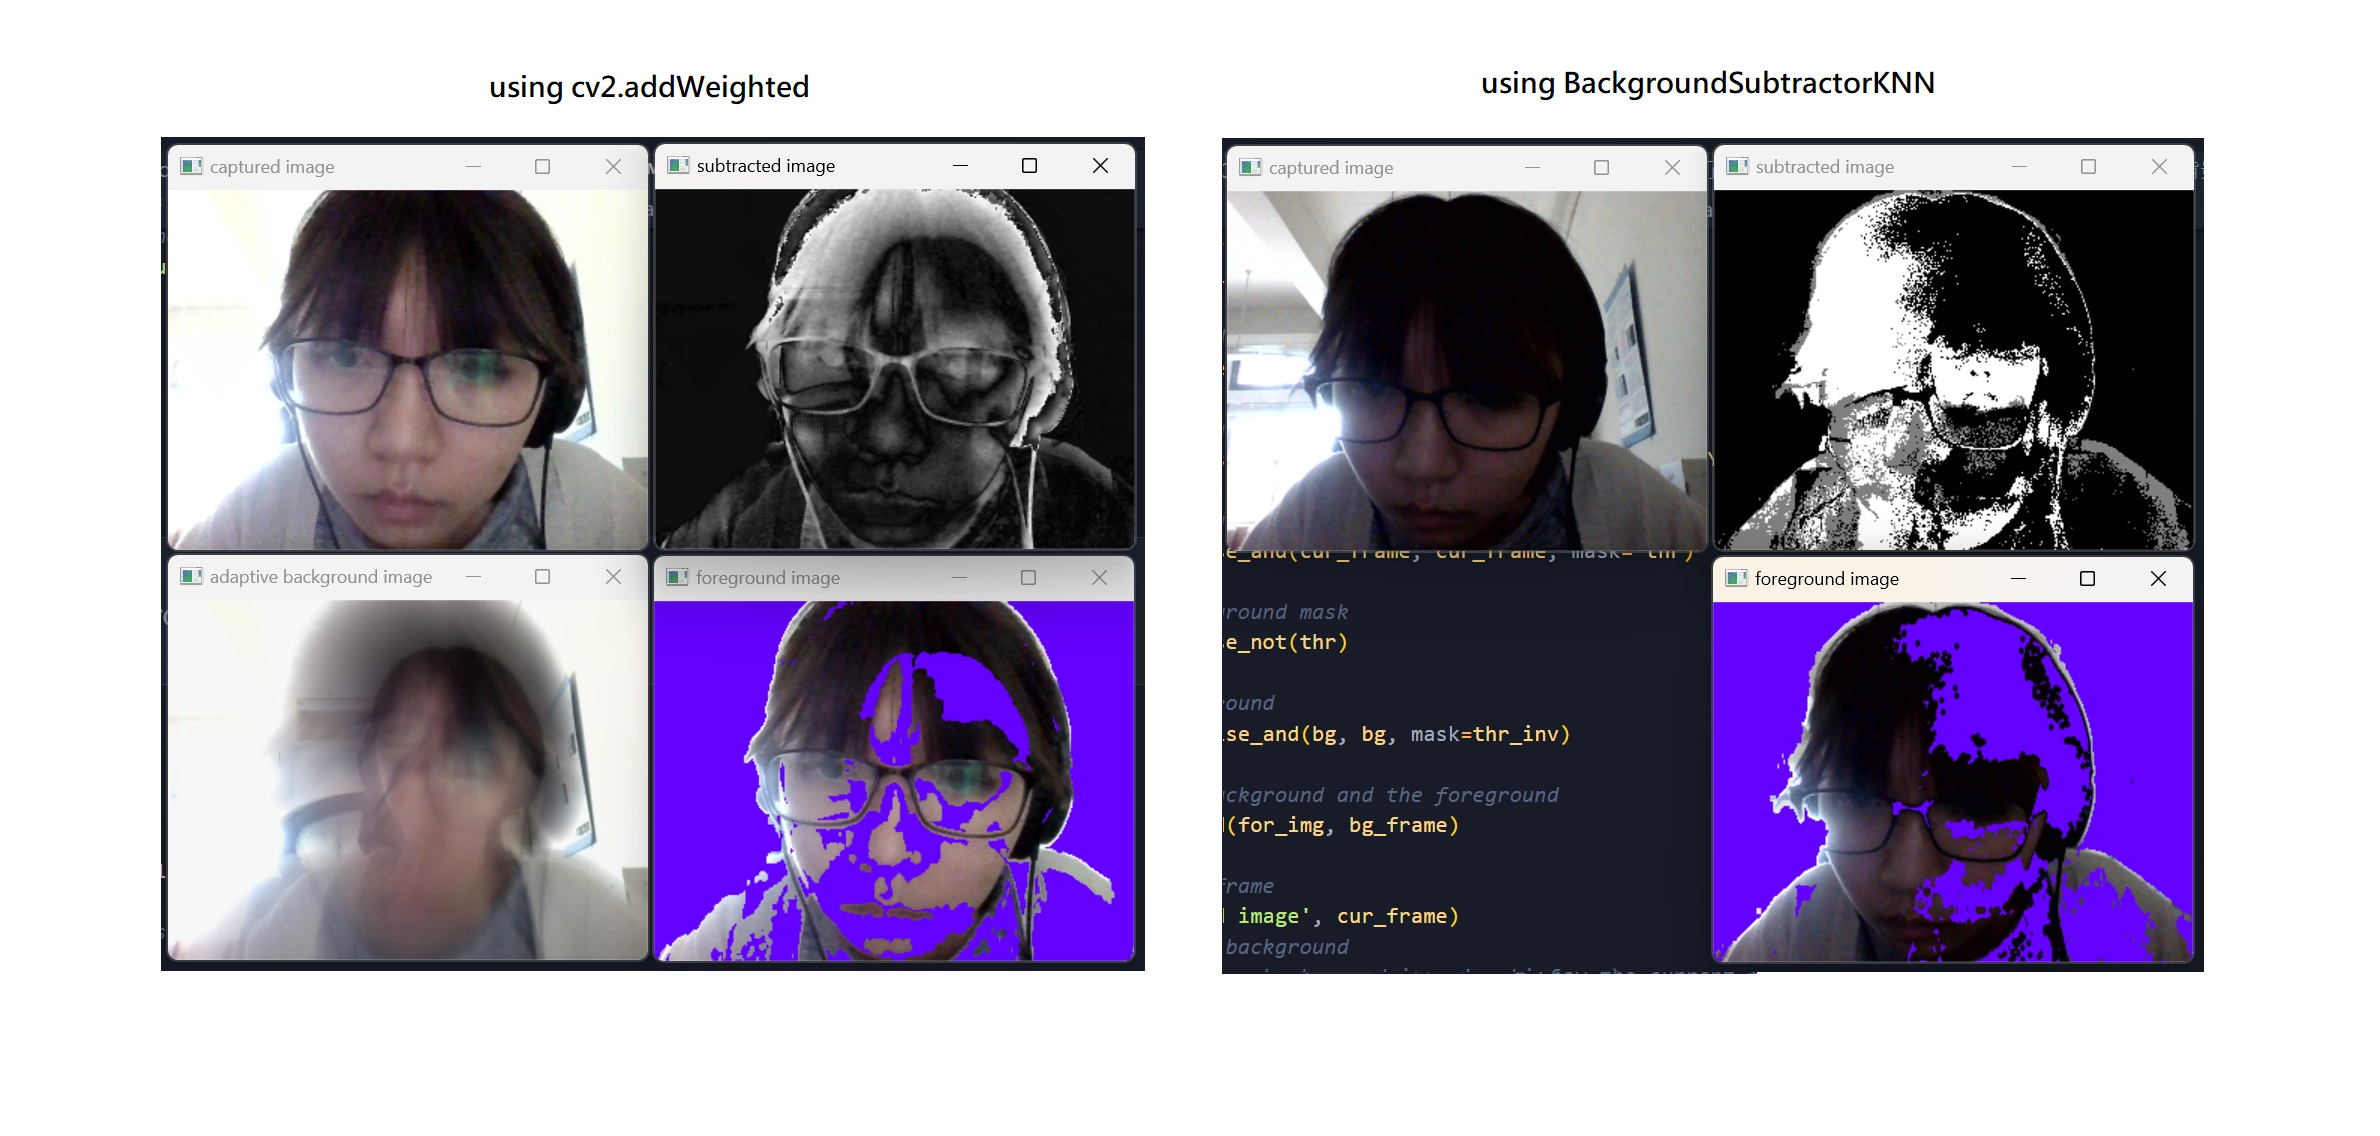